This notebook is just for exploring the Rico Segmentation dataset and seeing how a rearranging pipeline could look

### Downloading the Dataset

In [19]:
!wget -O unique_uis.tar.gz https://storage.googleapis.com/crowdstf-rico-uiuc-4540/rico_dataset_v0.1/unique_uis.tar.gz

--2024-03-18 09:05:16--  https://storage.googleapis.com/crowdstf-rico-uiuc-4540/rico_dataset_v0.1/unique_uis.tar.gz
Auflösen des Hostnamens storage.googleapis.com (storage.googleapis.com)… 142.251.209.155, 142.250.181.219, 172.217.19.91, ...
Verbindungsaufbau zu storage.googleapis.com (storage.googleapis.com)|142.251.209.155|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: 6471262799 (6,0G) [application/x-tar]
Wird in »unique_uis.tar.gz« gespeichert.

unique_uis.tar.gz   100%[===================>]   6,03G  36,9MB/s    in 3m 28s  

2024-03-18 09:08:44 (29,7 MB/s) - »unique_uis.tar.gz« gespeichert [6471262799/6471262799]



In [24]:
!tar -x --file=unique_uis.tar.gz combined/5373.jpg

In [25]:
!tar -x --file=unique_uis.tar.gz combined/5373.json

In [331]:
import json
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torchvision.transforms as transforms 
import torch.nn as nn
import tqdm

In [26]:
with open("combined/5373.json", "r") as f:
    image_json = json.load(f)

In [49]:
boxes = []
for i in image_json["activity"]["root"]["children"]:
    print(i["bounds"])
    boxes.append(i["bounds"])
    if "children" in i.keys():
        for child in i["children"]:
            print(child["bounds"])
            boxes.append(child["bounds"])

[0, 0, 1440, 2392]
[0, 0, 0, 0]
[0, 84, 1440, 2392]
[0, 2392, 1440, 2560]
[0, 0, 1440, 84]


In [81]:
def get_all_bounding_boxes(item):
    all_boxes = []
    if "bounds" in item.keys():
        all_boxes.append(item["bounds"])
    if "children" in item.keys():
        for child in item["children"]:
            for box in get_all_bounding_boxes(child):
                all_boxes.append(box)
    return all_boxes

In [82]:
boxes = get_all_bounding_boxes(image_json["activity"]["root"])

(0, 0)
(0, 0) 1440 2560
(0, 0)
(0, 0) 1440 2392
(0, 0)
(0, 0) 0 0
(0, 84)
(0, 84) 1440 2308
(0, 84)
(0, 84) 1440 2308
(0, 84)
(0, 84) 1440 2308
(0, 84)
(0, 84) 1440 2308
(0, 84)
(0, 84) 1440 2308
(0, 84)
(0, 84) 1440 2308
(0, 84)
(0, 84) 1440 909
(0, 84)
(0, 84) 1440 168
(1272, 84)
(1272, 84) 168 168
(0, 252)
(0, 252) 1440 741
(112, 252)
(112, 252) 491 93
(112, 373)
(112, 373) 848 142
(112, 571)
(112, 571) 888 242
(112, 841)
(112, 841) 538 76
(112, 917)
(112, 917) 444 76
(0, 2224)
(0, 2224) 1440 168
(1113, 2224)
(1113, 2224) 327 168
(0, 84)
(0, 84) 0 0
(0, 2392)
(0, 2392) 1440 168
(0, 0)
(0, 0) 1440 84


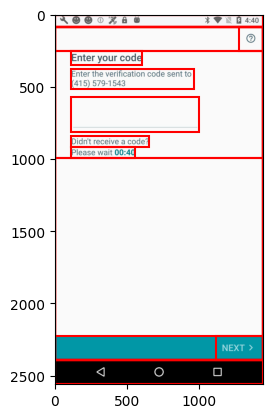

In [158]:
im = Image.open('combined/5373.jpg')
im = im.resize((1440, 2560), Image.Resampling.LANCZOS)

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)

for box in boxes:
    # Create a Rectangle patch
    #rect = patches.Rectangle((50, 100), 40, 30, linewidth=1, edgecolor='r', facecolor='none')
    anchor_point = (box[0],box[1])
    print(anchor_point)
    rect = patches.Rectangle(anchor_point, box[2]-box[0], box[3]-box[1], linewidth=1.5, edgecolor='r', facecolor='none')
    print(anchor_point, box[2]-box[0], box[3]-box[1])

# Add the patch to the Axes
    ax.add_patch(rect)

plt.show()

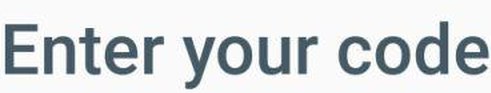

In [136]:
chosen_box = boxes[13]
cropped_image = im.crop((chosen_box[0],chosen_box[1],chosen_box[2],chosen_box[3]))
display(cropped_image)

In [164]:
# Both of these functions have to be differentiable, which is very hard to accomplish!


"""
returns a list of the segments and a list of coordinates
"""
def segment(image: np.ndarray, rico_json: dict)->[list,list]:
    boxes = get_all_bounding_boxes(rico_json["activity"]["root"])
    segments = []
    coordinates = []
    for box in boxes:
        anchor_point = (box[0],box[1])
        width = box[2]-box[0]
        height = box[3]-box[1]
        cropped_image = im.crop((box[0],box[1],box[2],box[3]))
        # Only include segments that are less than 90% the size of the original image
        if (width*height) < 0.9*(im.size[0]*im.size[1]):
            segments.append(cropped_image)
            coordinates.append((box[0],box[1]))
    return [segments,coordinates]

# This one is the more important one though
def reassemble(segments, coordinates):
    im = Image.new('RGB', (1440, 2560))
    for segment, coordinate in zip(segments,coordinates):
        im.paste(segment, coordinate)
    return im

In [138]:
len(segment(im,image_json)[0])

15

####################################################################################################


<PIL.Image.Image image mode=RGB size=0x0>

####################################################################################################


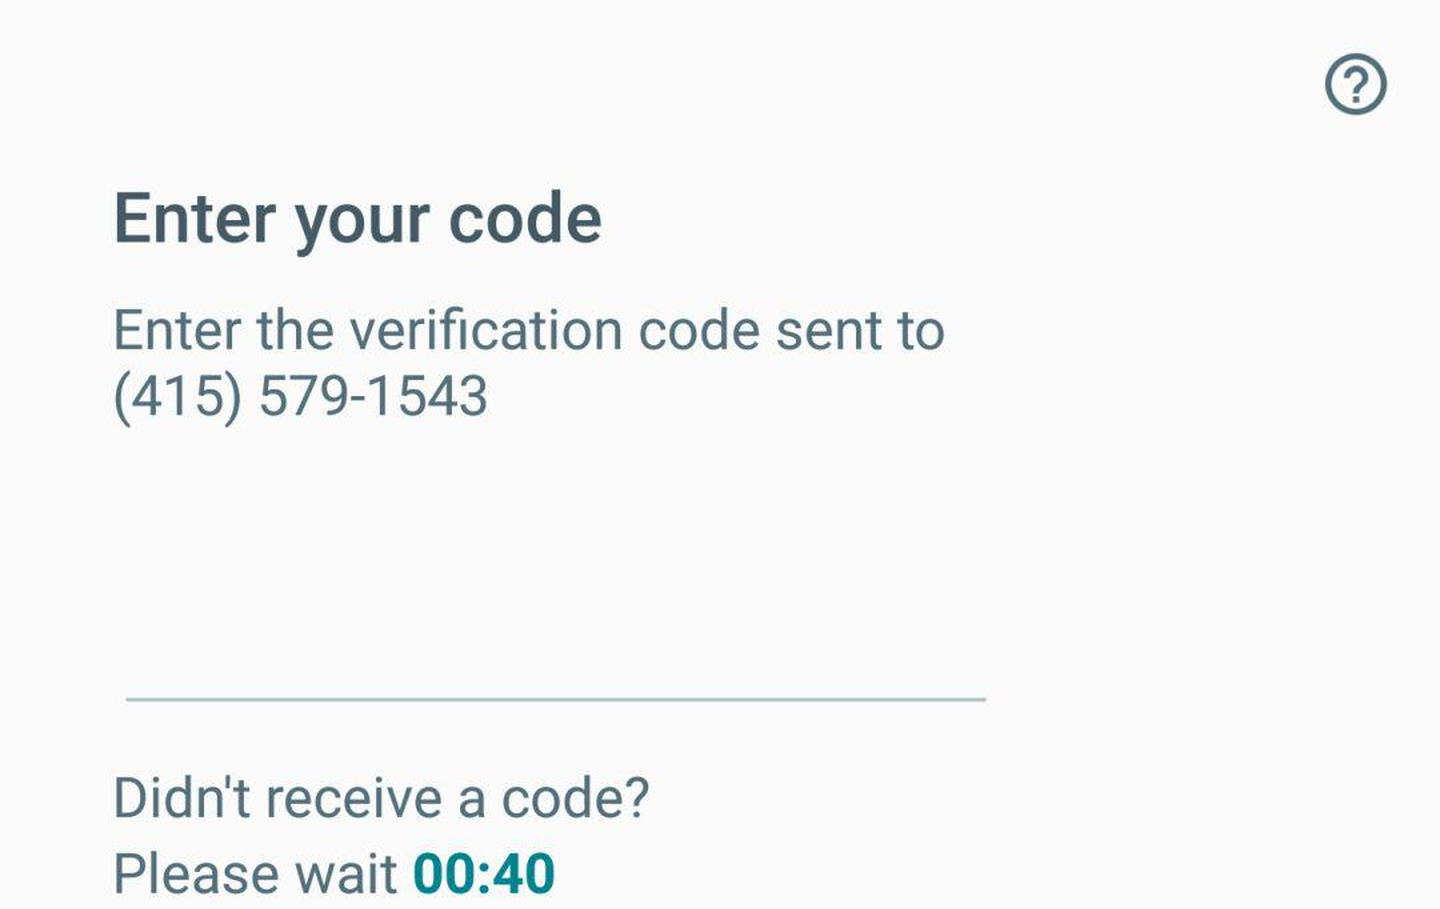

####################################################################################################


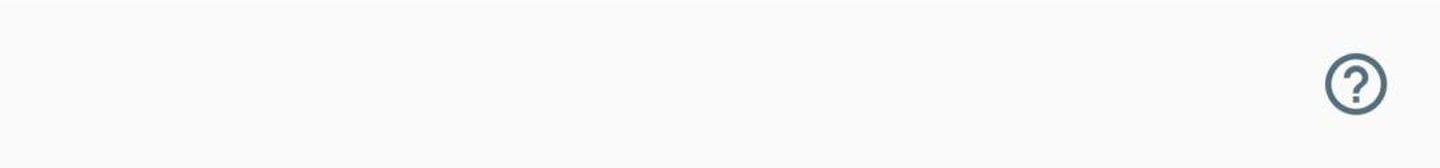

####################################################################################################


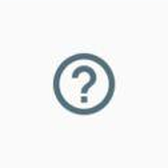

####################################################################################################


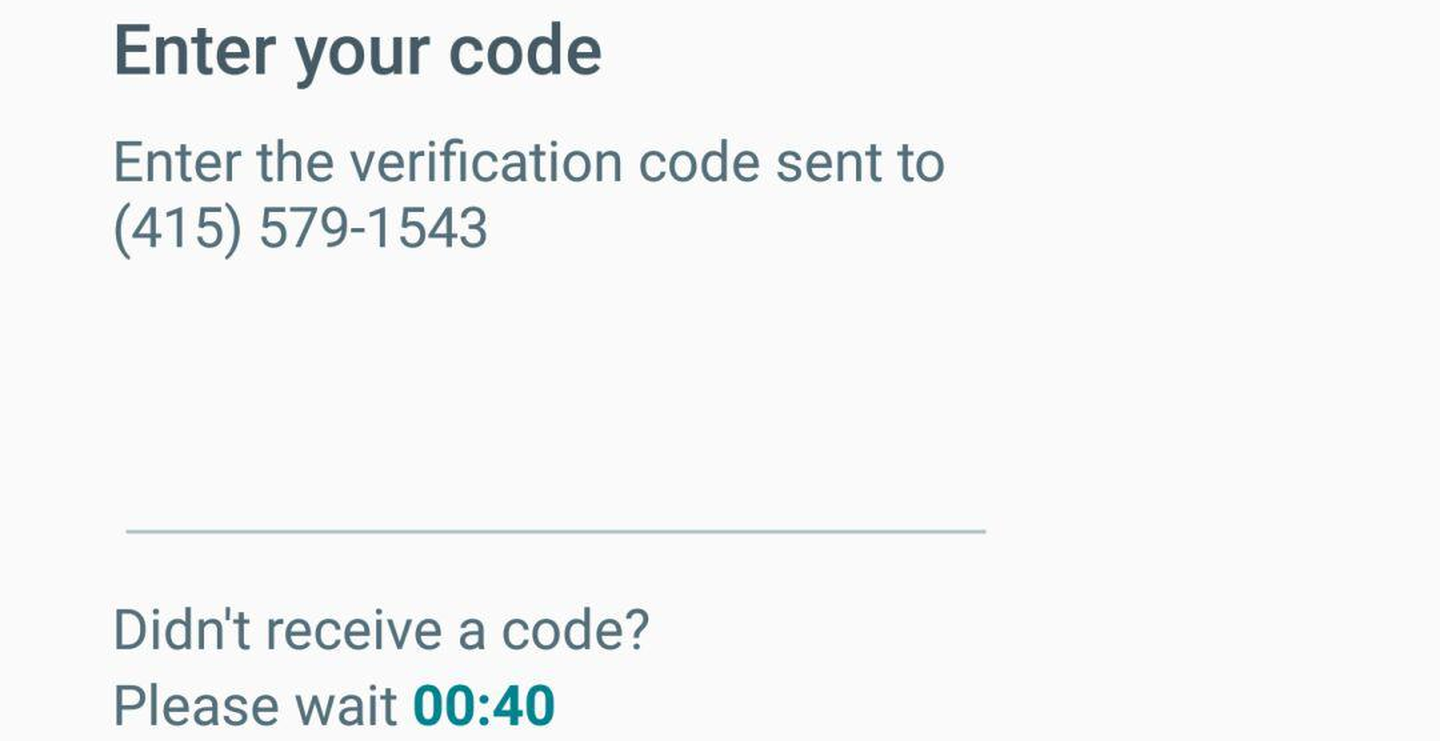

####################################################################################################


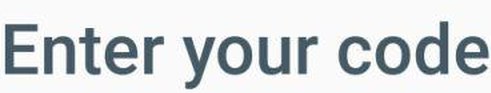

####################################################################################################


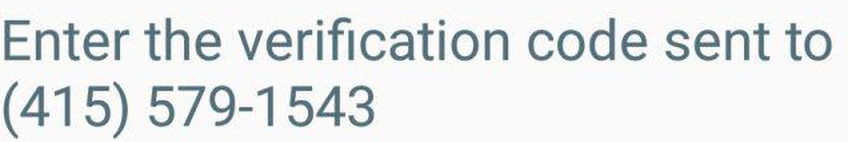

####################################################################################################


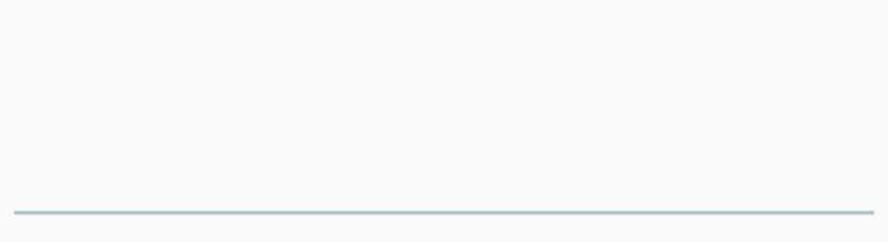

####################################################################################################


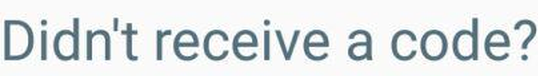

####################################################################################################


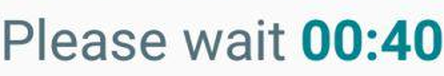

####################################################################################################


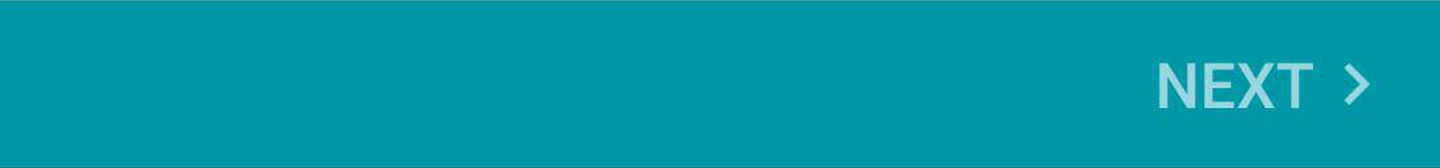

####################################################################################################


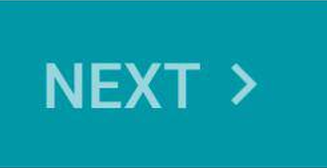

####################################################################################################


<PIL.Image.Image image mode=RGB size=0x0>

####################################################################################################


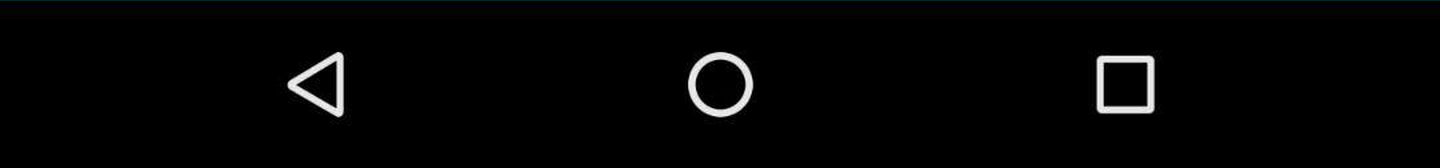

####################################################################################################


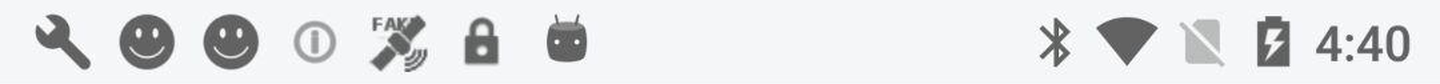

In [139]:
for imgg in segment(im,image_json)[0]:
    print("#"*100)
    display(imgg)

In [140]:
segments, coordinates = segment(im,image_json)

In [ ]:
reassembled_img = reassemble(segments,coordinates)

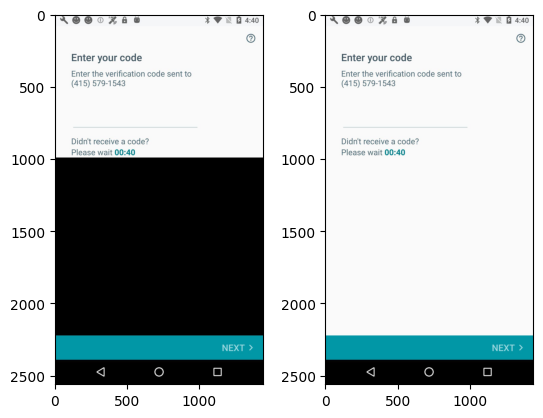

In [161]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(reassembled_img)
axarr[1].imshow(im)

In [150]:
coordinates

[(0, 0),
 (0, 84),
 (0, 84),
 (1272, 84),
 (0, 252),
 (112, 252),
 (112, 373),
 (112, 571),
 (112, 841),
 (112, 917),
 (0, 2224),
 (1113, 2224),
 (0, 84),
 (0, 2392),
 (0, 0)]

In [289]:
def reassemble_differentiable(segments, coordinates):
    im = torch.zeros(3, 2560, 1440, dtype=torch.uint8)  # assuming RGB images with the given dimensions

    # Iterate over each segment and its corresponding coordinate
    for i in range(len(segments)):
        segment = segments[i]
        coordinate = coordinates[i]

        # Get the size of the segment
        _, H, W = segment.size()

        # Ensure the coordinate is within bounds
        x, y = coordinate.unbind(-1)
        x0, y0 = torch.clamp(x, 0, 1440 - W), torch.clamp(y, 0, 2560 - H)

        # Calculate the region to paste the segment
        x1, y1 = x0 + W, y0 + H

        # Paste the segment into the image tensor
        im[:, y0:y1, x0:x1] = segment

    return im

In [290]:
transform = transforms.Compose([ 
    transforms.PILToTensor() 
]) 

In [291]:
def convert_all_segments_to_tensor(segments):
    tensors = []
    for segment in segments:
        tensors.append(transform(segment))
    return tensors

In [293]:
reassembled_img_diff = reassemble_differentiable(convert_all_segments_to_tensor(segments),torch.tensor(coordinates))

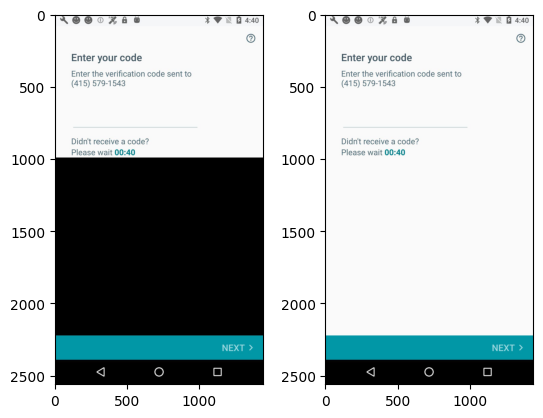

In [297]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(transform_to_pil(reassembled_img_diff))
axarr[1].imshow(im)

In [314]:
cd = np.array([list(x) for x in coordinates],dtype=np.float64)

In [351]:
cd

array([[   0.,    0.],
       [   0.,   84.],
       [   0.,   84.],
       [1272.,   84.],
       [   0.,  252.],
       [ 112.,  252.],
       [ 112.,  373.],
       [ 112.,  571.],
       [ 112.,  841.],
       [ 112.,  917.],
       [   0., 2224.],
       [1113., 2224.],
       [   0.,   84.],
       [   0., 2392.],
       [   0.,    0.]])

In [332]:
# We need to round the coordinates to next full integer as differentiation obviously needs floats which we cant use as coordinates
# Borrowed from https://discuss.pytorch.org/t/torch-round-gradient/28628/5
class differentiable_round(torch.autograd.function.InplaceFunction):
    @staticmethod
    def forward(ctx, input):
        ctx.input = input
        return torch.round(input)

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()
        return grad_input

In [347]:
class LayoutRerranger(nn.Module):
    def __init__(self, segments, initial_coordinates):
        self.segments = convert_all_segments_to_tensor(segments)
        
        super(LayoutRerranger, self).__init__()
        self.inp = nn.Parameter(torch.from_numpy(initial_coordinates).clone())

    def forward(self):
        c = self.inp
        c = differentiable_round.apply(c)

        # Create the image 
        im = torch.zeros(3, 2560, 1440, dtype=torch.uint8)

        # Iterate over each segment and its corresponding coordinate
        for i in range(len(self.segments)):
            segment = self.segments[i]
            coordinate = self.inp[i]
    
            # Get the size of the segment
            _, H, W = segment.size()
    
            # Ensure the coordinate is within bounds
            x, y = coordinate.unbind(-1)
            x0, y0 = torch.clamp(x, 0, 1440 - W), torch.clamp(y, 0, 2560 - H)
    
            # Calculate the region to paste the segment
            x1, y1 = x0 + W, y0 + H
    
            # Paste the segment into the image tensor
            print(y0,y1,x0,x1)
            im[:, y0:y1, x0:x1] = segment
        return im

In [348]:
lr = LayoutRerranger(segments, cd)
initial_inp_ng = lr.inp.clone()
optimizer_ng=torch.optim.SGD([lr.inp],lr=0.1, momentum=0.9)

In [349]:
epochs_to_run = 3

In [350]:
for x in tqdm.tqdm(range(epochs_to_run)):
    print(f"Epoch: {x}")
    print("Weights stayed the same:",torch.all(torch.eq(lr.inp,initial_inp_ng)))
    optimizer_ng.zero_grad()
    outputs=lr()
    print(outputs)
    score = outputs[0][0][0]
    # maximum_image_score = get_score_for_image(outputs)
    # Detach the autograd graph so we dont keep it in memory for our score tracking
    # scores.append([x,maximum_image_score.detach().clone().numpy().item()])
    loss = -score
    print(f"Loss: {loss}")
    loss.backward()
    optimizer_ng.step()

  0%|                                                                                                                                                               | 0/3 [00:00<?, ?it/s]

Epoch: 0
Weights stayed the same: tensor(True)
tensor(0., dtype=torch.float64, grad_fn=<ClampBackward1>) tensor(0., dtype=torch.float64, grad_fn=<AddBackward0>) tensor(0., dtype=torch.float64, grad_fn=<ClampBackward1>) tensor(0., dtype=torch.float64, grad_fn=<AddBackward0>)


TypeError: only integer tensors of a single element can be converted to an index